# Image Processing Concepts in OpenCV

Simple examples of image processing concepts on OpenCV. Concepts explored:

* Thresholding and masking
* Blurring
* Contours and bounding rectangles
* Edges
* Hough Transforms

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from pylab import rcParams
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['figure.figsize'] = (14,6)


## Binary thresholding

Here, the matter is straight forward. If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black). The function used is <b>cv2.threshold</b>. 

Examples 
- Using thresholding on brightness/darkness of grayscale image 
- Using thresholding on brightness/darkness on color ranges


### Binary thresholding on grayscale image

In [2]:
# read an image
img = cv2.imread('images/lenaColor.png')
# convert image to RGB color for matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def drawFunction(x):
    _, threshold_img = cv2.threshold(gray_img, x, 255, cv2.THRESH_BINARY)
    plt.imshow(threshold_img, cmap=cm.gray, vmin=0, vmax=255),plt.title('THRESHOLD'),plt.axis("off")
    

slider = widgets.FloatSlider(min=0, max=255, step=1, value=100)
interact(drawFunction, x=slider);



interactive(children=(FloatSlider(value=100.0, description='x', max=255.0, step=1.0), Output()), _dom_classes=('widget-interact',))

### Adaptive Thresholding

In the previous section, we used a global value as threshold value. But it may not be good in all the conditions where image has different lighting conditions in different areas. In that case, we go for adaptive thresholding. In this, the algorithm calculate the threshold for a small regions of the image. So we get different thresholds for different regions of the same image and it gives us better results for images with varying illumination.

(423, 419)


(<matplotlib.axes._subplots.AxesSubplot at 0x1116c59e8>,
 (-0.5, 418.5, 422.5, -0.5))

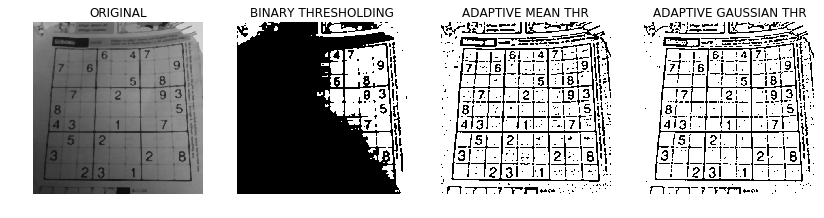

In [3]:
# read an image
img = cv2.imread('images/sudoku.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
img = cv2.medianBlur(img,5)


_,global_thresholding_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
adaptive_mean_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
adaptive_gaussian_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.subplot(141),plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255),plt.title('ORIGINAL'),plt.axis("Off")
plt.subplot(142),plt.imshow(global_thresholding_img, cmap=cm.gray, vmin=0, vmax=255),plt.title('BINARY THRESHOLDING'),plt.axis("off")
plt.subplot(143),plt.imshow(adaptive_mean_img, cmap=cm.gray, vmin=0, vmax=255),plt.title('ADAPTIVE MEAN THR'),plt.axis("off")
plt.subplot(144),plt.imshow(adaptive_gaussian_img, cmap=cm.gray, vmin=0, vmax=255),plt.title('ADAPTIVE GAUSSIAN THR'),plt.axis("off")

### Binary thresholding on color

In [4]:
# open new Mondrian Piet painting photo
piet = cv2.imread('images/piet.png')
piet_hsv = cv2.cvtColor(piet, cv2.COLOR_BGR2HSV)

<img src="images/hsv.png" style="width: 300px;">
HSV (Hue, Saturation, Value) is alternative representation of the RGB color model, designed in the 1970s by computer graphics researchers to more closely align with the way human vision perceives color-making attributes.

- Hue (Range 0-360) denotes location in light spectrum 
- Saturation (Range 0-1) represents intensity of color
- Value (Range 0-1) represents brightness or lightness of color

In OpenCV HSV range is: H: 0 to 179 (uses 7 bit) S: 0 to 255 V: 0 to 255

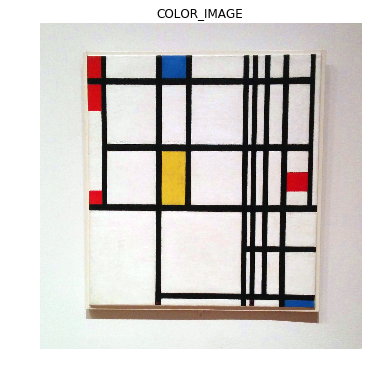

In [5]:
plt.title('COLOR_IMAGE'),plt.axis("off")
plt.imshow(cv2.cvtColor(piet, cv2.COLOR_BGR2RGB))

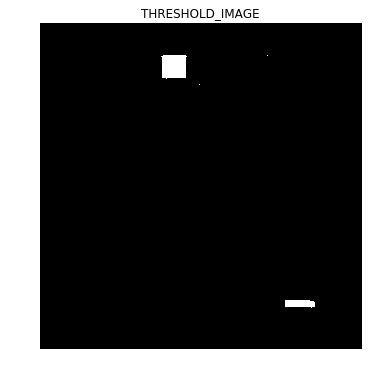

In [6]:
# threshold for hue channel in blue range
blue_min = np.array([85, 60, 60], np.uint8)
blue_max = np.array([150, 255, 255], np.uint8)
threshold_blue_img = cv2.inRange(piet_hsv, blue_min, blue_max)

plt.title('THRESHOLD_IMAGE'),plt.axis("off")
plt.imshow(threshold_blue_img,cmap=cm.gray, vmin=0, vmax=255)

### Using binary thresholding to obtain an image mask

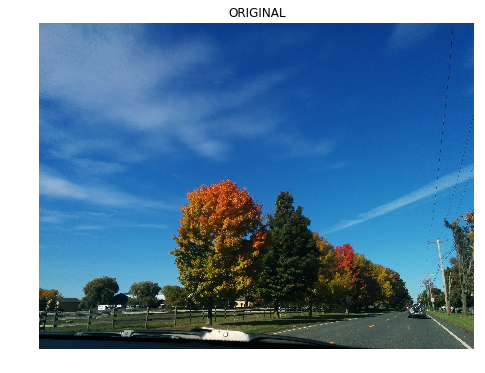

In [7]:
#Original Image
img = cv2.imread('images/upstate-ny.jpg')

plt.title('ORIGINAL'),plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

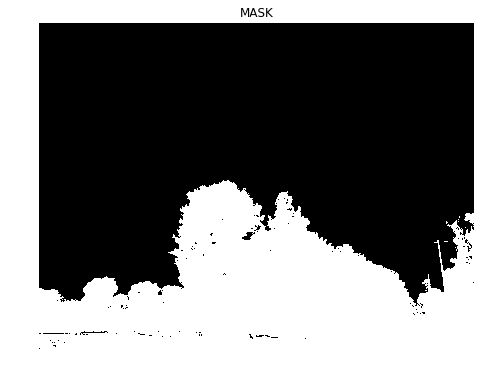

In [8]:
#HSV image for performing thresholding 
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#create mask
mask_inverse = cv2.inRange(img_hsv, blue_min, blue_max)
mask = cv2.bitwise_not(mask_inverse)

plt.title('MASK'),plt.axis("off")
plt.imshow(mask,cmap=cm.gray, vmin=0, vmax=255)

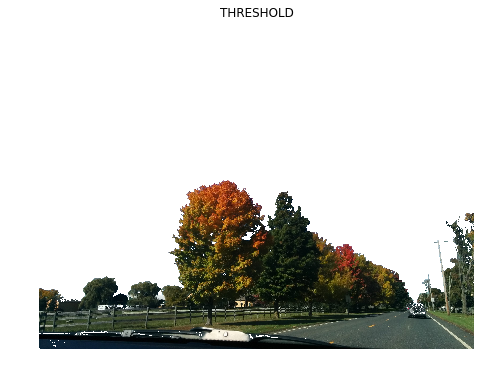

In [9]:
# convert single channel mask back into 3 channels
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# perform bitwise and on mask to obtain cut-out image that is not blue
masked_image = cv2.bitwise_and(img, mask_rgb)

# replace the cut-out parts with white
masked_replace_white = cv2.addWeighted(masked_image,1,cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB),1,0)

plt.title('THRESHOLD'),plt.axis("off")
plt.imshow(cv2.cvtColor(masked_replace_white, cv2.COLOR_BGR2RGB))

---
## Blur (Image filtering)

As in one-dimensional signals, images also can be filtered with various low-pass filters(LPF), high-pass filters(HPF) etc. 
LPF helps in removing noises, blurring the images etc. HPF filters helps in finding edges in the images.
### Averaging
As an example, we will try an averaging filter on an image. A 5x5 averaging filter kernel will look like below:
<img src="images/kernel.png"></img>
Operation is like this: keep this kernel above a pixel, add all the 25 pixels below this kernel, take its average and replace the central pixel with the new average value. It continues this operation for all the pixels in the image. 

### Gaussian Blur
In this, instead of box filter, gaussian kernel is used. 
<img src="images/GaussianKernel.png", width=600, height=300></img>
It is done with the function, <b>cv2.GaussianBlur()</b>. We should specify the width and height of kernel which should be positive and odd. We also should specify the standard deviation in X and Y direction, sigmaX and sigmaY respectively.
<img src="images/Gaussian_Equation.png"></img>
See Gaussian blurring in action, and how it makes a difference in the binary image that it produces

In [10]:
img = cv2.imread('images/oy.jpg')

def drawFunction(x):
    img_blur = cv2.GaussianBlur(img, (x,x), 0,0)
    plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('ORIGINAL'),plt.axis("off")
    plt.subplot(122),plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)),plt.title('BLUR IMAGE with K='+ str(x)),plt.axis("off")

slider = widgets.IntSlider(min=3, max=15, step=2, value=5)
interact(drawFunction, x=slider);

interactive(children=(IntSlider(value=5, description='x', max=15, min=3, step=2), Output()), _dom_classes=('widget-interact',))

## Noise Removal

Digital cameras often have quite some noise in their pictures. One can get rid of that noise using the Gaussian blur filter.

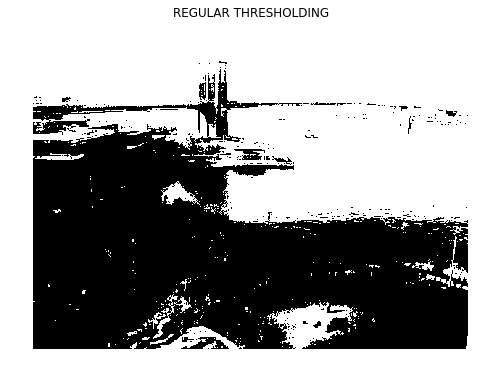

In [11]:
# threshold on regular image
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold_img = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY)

plt.title('REGULAR THRESHOLDING'),plt.axis("off")
plt.imshow(threshold_img,cmap=cm.gray, vmin=0, vmax=255)

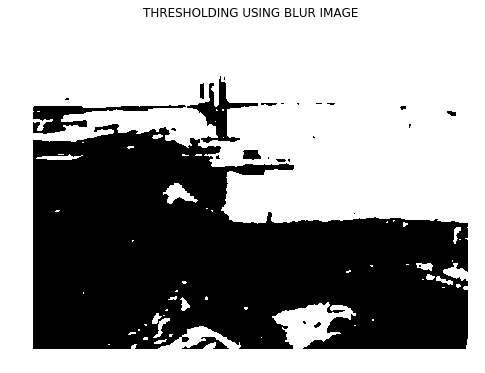

In [12]:
#threshold on blurred image
img_blur = cv2.GaussianBlur(img, (7,7), 0,0)
gray_blur_img = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
_, threshold_img_blur = cv2.threshold(gray_blur_img, 100, 255, cv2.THRESH_BINARY)

plt.title('THRESHOLDING USING BLUR IMAGE'),plt.axis("off")
plt.imshow(threshold_img_blur,cmap=cm.gray, vmin=0, vmax=255)

---

## Contour and bounding boxes

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

This is used to find the different features of image - contours, area, perimeter, centroid, bounding box etc
There are plenty of applications which uses this feature.

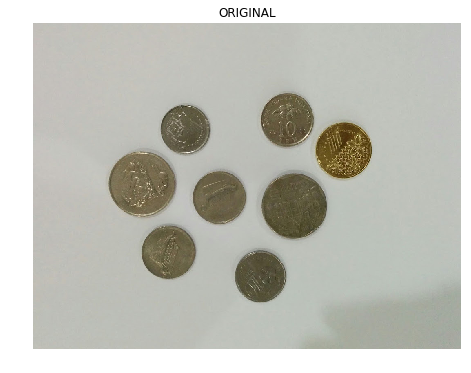

In [13]:
coins = cv2.imread('images/coins.jpg')

plt.title('ORIGINAL'),plt.axis("off")
plt.imshow(cv2.cvtColor(coins, cv2.COLOR_BGR2RGB))

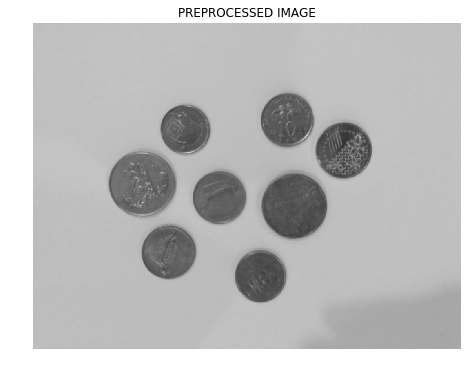

In [14]:
# get binary image and apply Gaussian blur
coins_gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
coins_preprocessed = cv2.GaussianBlur(coins_gray, (5, 5), 0)

plt.title('PREPROCESSED IMAGE'),plt.axis("off")
plt.imshow(coins_preprocessed,cmap=cm.gray, vmin=0, vmax=255)

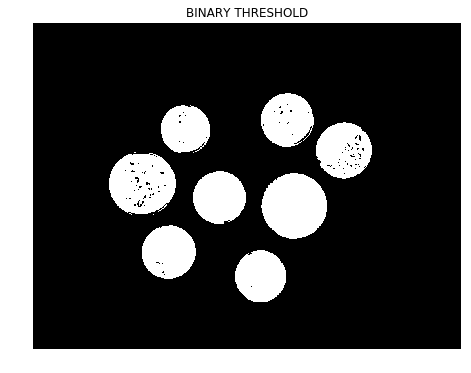

In [15]:
_, coins_binary = cv2.threshold(coins_preprocessed, 130, 255, cv2.THRESH_BINARY)

# invert image to get coins
coins_binary = cv2.bitwise_not(coins_binary)

plt.title('BINARY THRESHOLD'),plt.axis("off")
plt.imshow(coins_binary,cmap=cm.gray, vmin=0, vmax=255)

Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.

<b>Erosion -</b>
The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white). So what it does? The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

<b>Dilation -</b>
It is just opposite of erosion. Here, a pixel element is '1' if atleast one pixel under the kernel is '1'. So it increases the white region in the image or size of foreground object increases.

<b>Opening -</b>
Opening is just another name of erosion followed by dilation. It is useful in removing noise.

<b>Closing -</b>
Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

<img src="images/imgTransformation.jpg" , height=400, width=400> </img>

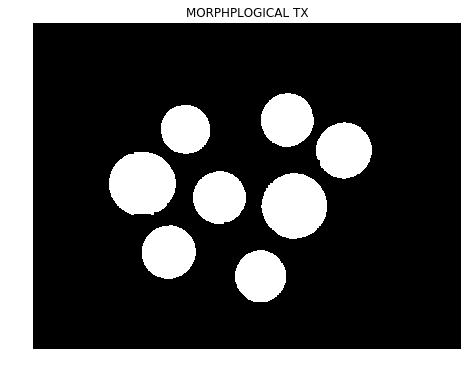

In [16]:
# morph coins by eroding and dilating to remove noise
morph_kernel = np.ones((15,15),np.uint8)
coins_morph = cv2.morphologyEx(coins_binary, cv2.MORPH_CLOSE, morph_kernel)

plt.title('MORPHPLOGICAL TX'),plt.axis("off")
plt.imshow(coins_morph,cmap=cm.gray, vmin=0, vmax=255)

---
### Get countours

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.
OpenCV has built in support to find the different features of contours, like area, perimeter, centroid, bounding box etc. which are useful for object detection.

NUMBER OF COINS: 8


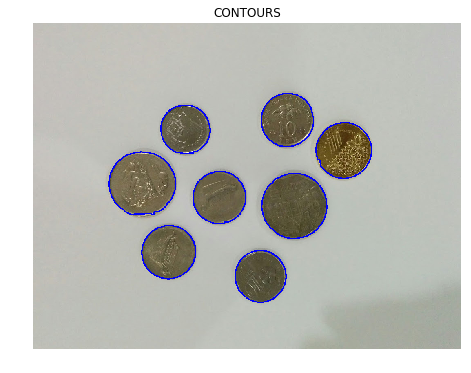

In [17]:
# find contours
_, coins_contours, _ = cv2.findContours(coins_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# make copy of image
coins_and_contours = np.copy(coins)

# find contours of large enough area
min_coin_area = 60
large_contours = [cnt for cnt in coins_contours if cv2.contourArea(cnt) > min_coin_area]

# draw contours
cv2.drawContours(coins_and_contours, large_contours, -1, (255,0,0),2)

plt.title('CONTOURS'),plt.axis("off")
plt.imshow(cv2.cvtColor(coins_and_contours, cv2.COLOR_BGR2RGB))

# print number of contours
print('NUMBER OF COINS: %d' % len(large_contours))

### Find bounding boxes

Bounding box (or a rectangular) and circle help in finding region of image (ROI) in an image in OpenCV.

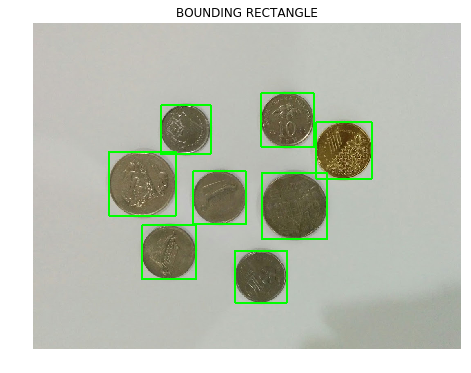

In [22]:
# create copy of image to draw bounding boxes
bounding_img = np.copy(coins)

# for each contour find bounding box and draw rectangle
for contour in large_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

plt.title('BOUNDING RECTANGLE'),plt.axis("off")
plt.imshow(cv2.cvtColor(bounding_img, cv2.COLOR_BGR2RGB))

## Edge detection
Canny edge detector in OpenCV. Usage of edge detection versus thresholding to obtain binary image.

Canny Edge Detection is a popular edge detection algorithm. It was developed by John F. Canny in 1986.

It is a multi-stage algorithm and we will go through each stages.

<b>Noise Reduction</b>
Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a 5x5 Gaussian filter. We have already seen this in previous session.

<b>Finding Intensity Gradient of the Image</b>
Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction ( Gx) and vertical direction ( Gy). From these two images, we can find edge gradient and direction for each pixel as follows:

$$Edge Gardient(G) = \sqrt{Gx^2+Gy^2}$$

$$Angle (θ)= tan^{-1}(\frac{Gy}{Gx})$$
Gradient direction is always perpendicular to edges. It is rounded to one of four angles representing vertical, horizontal and two diagonal directions.

<b>Non-maximum Suppression</b>

After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient. Check the image below:

<img src="images/nms.jpg" , height=400, width=400> </img>

Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is considered for next stage, otherwise, it is suppressed ( put to zero).

In short, the result you get is a binary image with "thin edges".

<b>Hysteresis Thresholding</b>

This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded. See the image below:

<img src="images/hysteresis.jpg" , height=400, width=400> </img>

The edge A is above the maxVal, so considered as "sure-edge". Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve. But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any "sure-edge", so that is discarded. So it is very important that we have to select minVal and maxVal accordingly to get the correct result.

This stage also removes small pixels noises on the assumption that edges are long lines.

So what we finally get is strong edges in the image.

(<matplotlib.axes._subplots.AxesSubplot at 0x1052d3eb8>,
 (-0.5, 499.5, 666.5, -0.5))

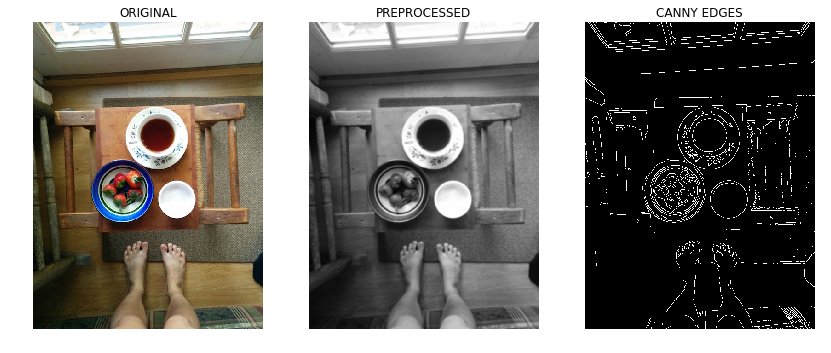

In [18]:
cups = cv2.imread('images/cups.jpg')
# preprocess by blurring and grayscale
cups_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(cups, (5,5), 0), cv2.COLOR_BGR2GRAY)
# find binary image with edges
cups_edges = cv2.Canny(cups_preprocessed, threshold1=90, threshold2=110)


plt.subplot(131),plt.imshow(cv2.cvtColor(cups, cv2.COLOR_BGR2RGB)),plt.title('ORIGINAL'),plt.axis("Off")
plt.subplot(132),plt.imshow(cups_preprocessed, cmap=cm.gray, vmin=0, vmax=255),plt.title('PREPROCESSED'),plt.axis("off")
plt.subplot(133),plt.imshow(cups_edges, cmap=cm.gray, vmin=0, vmax=255),plt.title('CANNY EDGES'),plt.axis("off")


---

## Hough Transform 

Example of using cv2.HoughCircles and cv2.HoughLines to detect circles and lines on an image.

Hough Transform is a popular technique to detect any shape, if you can represent that shape in mathematical form. It can detect the shape even if it is broken or distorted a little bit. We will see how it works for a line.

A line can be represented as 
$$y = mx+c$$ or in polar cordinate form, as $$\rho = x \cos \theta + y \sin \theta$$ 
where <b>ρ</b> is the perpendicular distance from origin to the line, 
and <b>θ</b> is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise ( That direction varies on how you represent the coordinate system. This representation is used in OpenCV). Check below image:
<img src="images/houghlines1.svg" , height=200, width=200> </img>
So if line is passing below the origin, it will have a positive rho and angle less than 180. Any vertical line will have 0 degree and horizontal lines will have 90 degree.

We convert the binary image (50,50) into <b>ρ</b> and <b>θ</b> plane (70,180). It is a 2D array with the number of rows equal to the number of <b>ρ</b> values and the number of columns equal to the number of <b>θ</b> values.

See how it works in visual way <a href="http://matlabtricks.com/post-39/understanding-the-hough-transform">here</a> and <a href="http://dersmon.github.io/HoughTransformationDemo/">here</a>

For each edge point and for each <b>θ</b> value, find the <b>ρ</b> value and increment that index in the accumulator. Each element tells how many points/pixels contributed.

Local maxima in the accumulator indicates the parameters of the most prominent lines in the input image.
Below figure shows how accumalation is done.

<img src="images/houghlinesdemo.gif"> </img>

Belwo figure shows how the lines are represented in 2D array in <b>ρ</b> and <b>θ</b> plane

<img src="images/houghlines2.jpg"> </img>

(<matplotlib.image.AxesImage at 0x1052a1518>,
 (-0.5, 499.5, 666.5, -0.5))

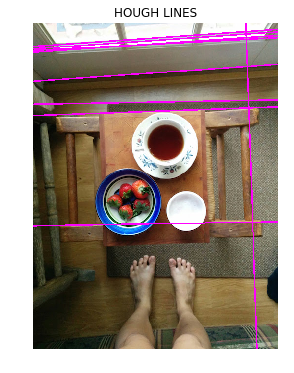

In [19]:
# line detection
sImage = cv2.imread('images/cups.jpg')
# preprocess by blurring and grayscale
sImage_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(cups, (5,5), 0), cv2.COLOR_BGR2GRAY)
# find binary image with edges
sImage_edges = cv2.Canny(sImage_preprocessed, threshold1=90, threshold2=110)
# copy of image to draw lines
sImage_lines = np.copy(sImage)


# find hough lines
num_pix_threshold = 120 # minimum number of pixels that must be on a line
lines = cv2.HoughLines(sImage_edges, 1, np.pi/180, num_pix_threshold)

for line in lines:
    for rho, theta in line:
        # convert line equation into start and end points of line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho 
        y0 = b * rho 

        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))

        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(sImage_lines, (x1,y1), (x2,y2), (255,0,255), 2)

plt.imshow(cv2.cvtColor(sImage_lines, cv2.COLOR_BGR2RGB)),plt.title('HOUGH LINES'),plt.axis("Off")

number of circles detected: 3


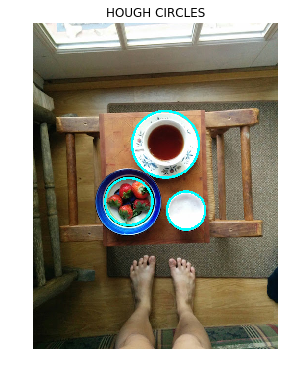

In [25]:
# find hough circles
circles = cv2.HoughCircles(cups_edges, cv2.HOUGH_GRADIENT, dp=1.5, minDist=50, minRadius=20, maxRadius=100)
cups_circles = np.copy(cups)

# if circles are detected, draw them
if circles is not None and len(circles) > 0:
    for (x, y, r) in circles[0]:
        x, y, r = int(x), int(y), int(r)
        cv2.circle(cups_circles, (x, y), r, (255, 255, 0), 4)
plt.imshow(cv2.cvtColor(cups_circles, cv2.COLOR_BGR2RGB)),plt.title('HOUGH CIRCLES'),plt.axis("Off")

print('number of circles detected: %d' % len(circles[0]))

In [26]:
print('The end!')

The end!
